# Import package and initiate

## import packages

In [1]:
import pandas as pd
import numpy as np

# import data33
data = pd.read_stata("/Users/valler/Python/OX_Thesis/OX_thesis/Data/ELSA/harmonised/H_ELSA_g2.dta")
df = pd.DataFrame(data[['idauniq','pn','rabyear','radyear']])

# death check 
df['radyear'].value_counts().sum()
# only 849 death information

# variable Record
df_multiple_response_record=pd.DataFrame(columns=['varname','maximum_missing_response','standardise','reverse_code','varset'])

# historical vars record 
df_historical_response_record=pd.DataFrame(columns=['varname','standardise','replace_dict','varset'])




In [9]:
# central control 
total_waves=2
latest_wave=2
health_wave=6
neighbor_wave=1 # only 1,3,7 available

## import data

In [3]:
df_multiple_response_record=pd.read_csv('/Users/valler/Python/OX_Thesis/OX_thesis/Data/ELSA/multiresponse_average.csv')
df_historical_response_record=pd.read_csv('/Users/valler/Python/OX_Thesis/OX_thesis/Data/ELSA/df_historical_response_record.csv')
df=pd.read_csv('/Users/valler/Python/OX_Thesis/OX_thesis/Data/ELSA/recoded_data.csv')

## basic functions 

In [2]:
# 1.2 

def gen_data_across_waves(varname_w1,total_waves,data):
    """
    generate the column names with the first column name
    when we need to draw information from multiple waves
    """
    var_names=[]
    for i in range(1,total_waves+1):
        var_names.append(varname_w1.replace('1',str(i)))
    temp = data[var_names]
    return temp

def count_times(df_row,response_to_count):
    """
    send the row and response to count, to count the times that the 
    response has appeared in ech row/ppl
    e.g. df['rentperiod'] = temp.apply(count_times,axis=1,response_to_count='1.own home')
    """
    count=0
    for item in df_row:
        if item==response_to_count:
            count+=1
    return count


def average_response_by_row(df_row,maximum_missing_response):
    """
    for vars that draw info from multiple variables, this
    function help to average them with maximum_missing_response
    # df_row should be sliced data
    """
    
    missing_count=sum(pd.isnull(df_row))
    if missing_count>=maximum_missing_response:
        return None
    else:
        df_row=[x for x in df_row if not pd.isnull(x)]
        return sum(df_row)/len(df_row)



## multiple_response functions

In [3]:


def add_row_to_df_multiple_response_record(new_row,df_multiple_response_record):
    """
    add row to df_multiple_response_record
    if the row exists, firstly drop then add 
    """
    varname= new_row['varname']
    if varname in list(df_multiple_response_record['varname']):
        # only keep those rows that doesn't match the new varname
        df_multiple_response_record=df_multiple_response_record.where(df_multiple_response_record['varname']!=varname)
        df_multiple_response_record.dropna(inplace=True)
    df_multiple_response_record=df_multiple_response_record.append(new_row,ignore_index=True)
    return df_multiple_response_record

def multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control):
    """
    automation of average to multiple response
    """
    
    sliced_row = df_multiple_response_record.loc[df_multiple_response_record['varname']==varname,]
    varset=sliced_row['varset'].values[0]
    maximum_missing_response=sliced_row['maximum_missing_response'].values[0]
    reverse_control=sliced_row['reverse_code'].values[0]
    
    sliced_data = data[varset].copy()
    
    # print_missing counts info
    if print_missing_count_control:
        missing_count(sliced_data)
    
    print(f'1. maximum_missing_response {maximum_missing_response}\n2. reverse_control {reverse_control}')
    
    # replace string to number 
    replace_dict=replace_response_with_value(sliced_data)
    print("3. the replace dict is {}".format(replace_dict))
    sliced_data.replace(replace_dict,inplace=True)
    
    # reverse control
    if reverse_control:
        
        unique_vals = get_unique_valaues(sliced_data)
        print("4. unique_vals are {}".format(unique_vals))
        replace_dict = generate_value_replace_dict(unique_vals)
        print("5. dict is {}".format(replace_dict))
        sliced_data.replace(replace_dict,inplace=True)
    
    # if there is only one variable, set it to the df directly rather than averaging them 
    if len(varset)==1:
        df[varname]=sliced_data[varset[0]]
    else:    
        df[varname]=sliced_data.apply(average_response_by_row,axis=1,maximum_missing_response=maximum_missing_response)
    
    return df

def generate_value_replace_dict(res_lst):
    """
    return the replace dict for reverse coding 
    """
    replace_dict={}
    max_val=max(res_lst)
    res_lst.sort()
    res_len=len(res_lst)
    
    for index in range(res_len):
        reverse_ind = res_len-index-1
        replace_dict[res_lst[index]]=res_lst[reverse_ind]
    return replace_dict  

def get_unique_valaues(sliced_data):
    """
    if we need to treat values from all columns as a whole,
    this function help to get the unique value list
    """
    unique_list=[]
    for column in sliced_data.columns:
        unique_list+=list(sliced_data[column].unique())
    
    # delete repeat value
    unique_list=list(set(unique_list))
    
    # get rid of nans
    unique_list= [x for x in unique_list if not pd.isnull(x)]
    return unique_list


def replace_response_with_value(sliced_data):
    """
    replace the string response with numbers 
    # here by default we assume all the values are format of '#. explain'
    # e.g. '1.hardly ever or never'
    """
    replace_dict={}
    response_list = get_unique_valaues(sliced_data)
    
    # generate the dict
    for res in response_list:
        if isinstance(res,str):
            number=res.split('.')[0]
            replace_dict[res]=int(number)
        elif isinstance(res,float) or isinstance(res,int):
            number=res
            replace_dict[res]=int(number)
        else:
            print('the response is incorrect, {}, type{}'.format(res,type(res)))
        
        
    return replace_dict

def missing_count(sliced_data):
    """
    print the missing counts in each row, account for all columns in var_set
    """
    
    def return_sum_of_null(row):
        missing_count=sum(pd.isnull(row))
        return missing_count
    sliced_data['missing_count']=sliced_data.apply(return_sum_of_null,axis=1)
    print("0. missing information -------- start")
    print(sliced_data['missing_count'].value_counts())
    sliced_data.drop(columns=['missing_count'],inplace=True)
    
    

## historical response recorder

In [4]:


def add_row_to_df_historical_response_record(new_row,df_historical_response_record):
    """
    add row to df_historical_response_record
    if there is replace_dict found, ask to replace it or not
    if the row exists, firstly drop then add 
    """
    varname= new_row['varname']
    
    if varname in list(df_historical_response_record['varname']):
        
        exist_row=df_historical_response_record.loc[df_historical_response_record['varname']==varname,:]
        replace_dict=exist_row['replace_dict'].values[0]
        replace_control = 1 # by deafualt, we update the dict
        
        # if we have found replace_dict -> choose to update it or not 
        if not pd.isnull(replace_dict) and isinstance(replace_dict,dict):
            stay_control=True
            while stay_control:
                print('we have found the dict as follows')
                for key in replace_dict.keys():
                    print('{}->{}'.format(key,replace_dict[key]))
                    
                replace_control=input("do you want to update it? 1->yes 0->no")
                try:
                    replace_control=int(replace_control)
                    if replace_control in [1,0]:
                        stay_control=False
                    else:   
                        print('please check your response and try again')
                except:
                    print('please check your response and try again')
        
        # first delete original rows df_historical_response_record 
        df_historical_response_record=df_historical_response_record.where(df_historical_response_record['varname']!=varname)
        df_historical_response_record.dropna(inplace=True)
        df_historical_response_record=df_historical_response_record.append(new_row,ignore_index=True)

        if  replace_control==0:  # not update, keep the original one
            print('we will keep the original replace_dict')
            df_historical_response_record.loc[df_historical_response_record['varname']==varname,'replace_dict']=[replace_dict]
        
    else:
        df_historical_response_record=df_historical_response_record.append(new_row,ignore_index=True)
    return df_historical_response_record


def historical_response_recorder(varname,df_historical_response_record,data,df):
    """
    check whether there is any affimative response to the question, if exists (doesn't matter how many times) ->1
    """
    sliced_row = df_historical_response_record.loc[df_historical_response_record['varname']==varname,]
    varset=sliced_row['varset'].values[0]
    sliced_data = data[varset].copy()

    # get the replace_dict by inputting or from df_historical_response_record
        
    replace_dict=generate_replace_dict_for_historical_response(sliced_row,sliced_data)
    replace_dict['nan']=None
    # record the replace_dict
    
    df_historical_response_record.loc[df_historical_response_record['varname']==varname,'replace_dict']=[replace_dict]
    
    # here all the values will be changed to 1/-1 value
    # first convert all columns to str (could be categorical)
    # for col in sliced_data.columns:
        # sliced_data[col].replace(replace_dict,inplace=True)
        # sliced_data[col]=sliced_data[col].astype('str')
        
    # print(f'unique values are {get_unique_valaues(sliced_data)}')
    # print(sliced_data.value_counts())
    print(f'\n1.the replace dict is \n{replace_dict}')
    
    sliced_data.replace(replace_dict,inplace=True)
    
    
    # if there is only one variable being sent -> set the sliced_data to df directly
    if len(varset)==1:
        
        df[varname]=sliced_data[varset[0]]
    else:
        # mark response 
        df[varname]=sliced_data.apply(mark_positive_response,axis=1)
        
    return df,df_historical_response_record


def generate_replace_dict_for_historical_response(sliced_row,sliced_data):
    """
    generate the replace_dict if there is nothing in sliced_row['replace_dict']/returned object is not dict
    """
    replace_dict=sliced_row['replace_dict'].values[0]
    
    # if we had done it, we shouldn't do it again..
    if pd.isnull(replace_dict) or not isinstance(replace_dict,dict):
        replace_dict={}
        response_list = get_unique_valaues(sliced_data)

        for response in response_list:
            Pass_control=True
            while Pass_control:
                replace_val=input(f'replace response [{response}] with int ..')
                try:
                    replace_val=int(replace_val)
                    Pass_control=False
                except:
                    print('error in the response, please try again')
            replace_dict[response]=replace_val
    
    return replace_dict
    
def mark_positive_response(df_row):
    """
    if 1 exists in df_row, mark it as 1 else -1
    """
    if 1 in list(df_row):
        return 1
    else:
        return -1
    


# Demographics

In [5]:
# 2.1. Age should be decide later! as this will be thee base line
# the var name is r#agey, replace # by the interview wave number, age aat interview

## Gender `male`

In [6]:
# 2.2 
df['male']=[1 if x=='1.man' else -1 for x in data['ragender']]
df['male'].value_counts()
# 9012 men, 10790 women

-1    10790
 1     9012
Name: male, dtype: int64

##  Race `white` 

In [7]:
# 2.3 
df['white']=[1 if x=='1.white' else -1 for x in data['raracem']]
df['white'].value_counts()

 1    18879
-1      923
Name: white, dtype: int64

## Foreign Born `migrantYN`
`w1-w9` `latest_wave`

In [10]:
varset=['rabcountry'.format(latest_wave)] 

new_row={'varname':'migrantYN',
         'varset':varset,
         'standardise':True,
        'replace_dict':{'0.out of country': 1, '1.in country': -1, 'nan': None}}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)

# df[varname]=df[varname].fillna(-1)
df[varname].value_counts()



1.the replace dict is 
{'0.out of country': 1, '1.in country': -1, 'nan': None}


-1.0    17775
 1.0     1937
Name: migrantYN, dtype: int64

## New Current Marital Status: With Partnership, `currentpaternered`

whether the respondent is parternered now (latest wave) 

1 → married, paternered

-1 → otherwise


`w1-w9` `latest_wave`

step 1: firstly through the marital status 

In [11]:
print_missing_count_control=False

varset=['r{}mstat'.format(latest_wave)] 

# varset=[varset[0].replace('1',str(x)) for x in range(1,latest_wave+1)]


new_row={'varname':'currentpaternered',
         'varset':varset,
         'standardise':True,
        'replace_dict':{'1.married': 1, '4.separated': -1, '8.never married': -1, '3.partnered': 1, '5.divorced': -1, '7.widowed': -1, 'nan': None}}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)

df[varname]=df[varname].fillna(-1)
df[varname].value_counts()



1.the replace dict is 
{'1.married': 1, '4.separated': -1, '8.never married': -1, '3.partnered': 1, '5.divorced': -1, '7.widowed': -1, 'nan': None}


-1.0    13217
 1.0     6585
Name: currentpaternered, dtype: int64

 Step 2 Then through the implied partnership status

In [12]:
implied_status='r{}mpart'.format(latest_wave)
df['currentpaternered']=[1 if x=='1.yes' else y for x,y in zip(data[implied_status],df['currentpaternered'])]
df['currentpaternered'].value_counts()

-1.0    13217
 1.0     6585
Name: currentpaternered, dtype: int64

# Childhood Adversity (7)

## Paternal Education  `Zfatherseduc`

`single wave` `reverse code`

In [13]:
# radadeduage
data['radadeduage'].value_counts()

2.age 14 or under          8006
3.at age 15                1616
4.at age 16                1012
7.age 19 or over            655
6.at age 18                 374
5.at age 17                 205
1.never went to school      178
Name: radadeduage, dtype: int64

In [14]:
# descending manner 
# higher value -> lower education
print_missing_count_control=False

varset=['radadeduage'] 

# varset=[x.replace('1',str(neighbor_wave)) for x in varset]

# gen record
new_row={'varname':'Zfatherseduc',
         'varset':varset,
         'maximum_missing_response':0,
         'standardise':True,
        'reverse_code':True}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

1. maximum_missing_response 0
2. reverse_control True
3. the replace dict is {'4.at age 16': 4, '6.at age 18': 6, '1.never went to school ': 1, '2.age 14 or under': 2, '3.at age 15': 3, '7.age 19 or over': 7, '5.at age 17': 5}
4. unique_vals are [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
5. dict is {1.0: 7.0, 2.0: 6.0, 3.0: 5.0, 4.0: 4.0, 5.0: 3.0, 6.0: 2.0, 7.0: 1.0}


count    12046.000000
mean         5.265482
std          1.398184
min          1.000000
25%          5.000000
50%          6.000000
75%          6.000000
max          7.000000
Name: Zfatherseduc, dtype: float64

## Maternal Education `Zmotherseduc`

`single wave` `reverse`

In [15]:
data['ramomeduage'].value_counts()

2.age 14 or under          7795
3.at age 15                1915
4.at age 16                1223
7.age 19 or over            421
6.at age 18                 383
1.never went to school      258
5.at age 17                 234
Name: ramomeduage, dtype: int64

In [17]:
# descending manner 
# higher value -> lower education
print_missing_count_control=False

varset=['ramomeduage'] 

# varset=[x.replace('1',str(neighbor_wave)) for x in varset]

# gen record
new_row={'varname':'Zmotherseduc',
         'varset':varset,
         'maximum_missing_response':0,
         'standardise':True,
        'reverse_code':True}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

1. maximum_missing_response 0
2. reverse_control True
3. the replace dict is {'4.at age 16': 4, '6.at age 18': 6, '1.never went to school ': 1, '2.age 14 or under': 2, '3.at age 15': 3, '7.age 19 or over': 7, '5.at age 17': 5}
4. unique_vals are [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
5. dict is {1.0: 7.0, 2.0: 6.0, 3.0: 5.0, 4.0: 4.0, 5.0: 3.0, 6.0: 2.0, 7.0: 1.0}


count    12229.000000
mean         5.309674
std          1.278783
min          1.000000
25%          5.000000
50%          6.000000
75%          6.000000
max          7.000000
Name: Zmotherseduc, dtype: float64

## 2 Parental Occupation `carersocc`

To mimic Lower Father Occupational Status

`4.other` category is setting to missing as we don't know what it means

`3.military` -> `1.white collar`

`ramaoccup` `single variable`

In [18]:
data['ramaoccup'].value_counts()

2.blue collar     9178
1.white collar    5013
4.other           4136
3.military         523
Name: ramaoccup, dtype: int64

In [19]:
# descending manner 
# higher value -> lower occupation
print_missing_count_control=False

varset=['ramaoccup'] 

# varset=[x.replace('1',str(neighbor_wave)) for x in varset]

# gen record
new_row={'varname':'carersocc',
         'varset':varset,
         'maximum_missing_response':0,
         'standardise':True,
        'reverse_code':False}

df_multiple_response_record = add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

# replace 
replace_dict={4:None,3:1}
df[varname]=df[varname].replace(replace_dict)
df[varname].describe()

1. maximum_missing_response 0
2. reverse_control False
3. the replace dict is {'2.blue collar': 2, '1.white collar': 1, '4.other': 4, '3.military': 3}


count    14714.000000
mean         1.623760
std          0.484458
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: carersocc, dtype: float64

In [20]:
df[varname].value_counts()

2.0    9178
1.0    5536
Name: carersocc, dtype: int64

## Lower Childhood Health Status `rachshlt`

To replace Child Psychosocial Adversity  sumCAE? (don't think they are the same but, yah.

`single variable` `rachshlt` 

higher value -> lower health status

In [21]:
data['rachshlt'].value_counts()

1.excellent                     2710
2.very good                     2603
3.good                          1593
4.fair                           645
5.poor                           259
6.health varied a great deal      33
Name: rachshlt, dtype: int64

In [22]:
# descending manner 
print_missing_count_control=False

varset=['rachshlt'] 

# varset=[x.replace('1',str(neighbor_wave)) for x in varset]

# gen record
new_row={'varname':'rachshlt',
         'varset':varset,
         'maximum_missing_response':0,
         'standardise':True,
        'reverse_code':True}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']

# replace 
replace_dict={"6.health varied a great deal":None}
data[varname]=data[varname].replace(replace_dict)

df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)


df[varname].describe()

1. maximum_missing_response 0
2. reverse_control True
3. the replace dict is {'3.good': 3, '2.very good': 2, '4.fair': 4, '5.poor': 5, '1.excellent': 1}
4. unique_vals are [1.0, 2.0, 3.0, 4.0, 5.0]
5. dict is {1.0: 5.0, 2.0: 4.0, 3.0: 3.0, 4.0: 2.0, 5.0: 1.0}


count    7810.000000
mean        3.878361
std         1.079408
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rachshlt, dtype: float64

# Adulthood Socioeconomic (13)

## 8 History of Divorce `everdivorced`

`historical response`

In [23]:

varset=['r1mstat'] 

varset=[varset[0].replace('1',str(x)) for x in range(1, latest_wave+1)]

new_row={'varname':'everdivorced',
         'varset':varset,
         'standardise':True,
        'replace_dict':None}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)

df[varname]=df[varname].fillna(-1)
df[varname].value_counts()


replace response [3.partnered] with int ..-1
replace response [4.separated] with int ..1
replace response [5.divorced] with int ..1
replace response [1.married] with int ..-1
replace response [7.widowed] with int ..-1
replace response [8.never married] with int ..-1

1.the replace dict is 
{'3.partnered': -1, '4.separated': 1, '5.divorced': 1, '1.married': -1, '7.widowed': -1, '8.never married': -1, 'nan': None}


-1    18708
 1     1094
Name: everdivorced, dtype: int64

 new Length of Longest Marriage (Including Current)?  `longestmarriage`
`w1-w9`

<AxesSubplot:>

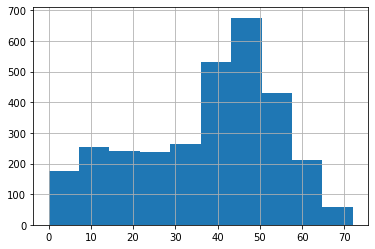

In [32]:
data['r9mlen'].hist()

## 9 Never Married `nevermarried`
`latest_wave`

In [24]:
# r never married

varname= 'r{}mnev'.format(latest_wave)

new_row={'varname':'nevermarried',
         'varset':varset,
         'standardise':True,
        'replace_dict':None}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)

df[varname]=df[varname].fillna(-1)
df[varname].value_counts()


replace response [3.partnered] with int ..-1
replace response [4.separated] with int ..-1
replace response [5.divorced] with int ..-1
replace response [1.married] with int ..-1
replace response [7.widowed] with int ..-1
replace response [8.never married] with int ..1

1.the replace dict is 
{'3.partnered': -1, '4.separated': -1, '5.divorced': -1, '1.married': -1, '7.widowed': -1, '8.never married': 1, 'nan': None}


-1    19205
 1      597
Name: nevermarried, dtype: int64

## 43 Lower Income  `ZincomeT`

`w1-w9` `latest_wave`

In [25]:
varname = 'h{}itot'.format(latest_wave)

df['ZincomeT']=data[varname]
df['ZincomeT'].describe()


count      9310.000000
mean      20747.097656
std       19974.613281
min        -643.000000
25%       10324.250000
50%       16380.300781
75%       25302.638672
max      502850.531250
Name: ZincomeT, dtype: float64

## 44 Lower Wealth `ZwealthT`

`w1-w9` `latest_wave`

In [26]:
varname = 'h{}atotb'.format(latest_wave)

df['ZwealthT']=data[varname]
df['ZwealthT'].describe()


count    9.310000e+03
mean     2.635464e+05
std      3.921377e+05
min     -1.269900e+05
25%      8.986850e+04
50%      1.875000e+05
75%      3.200000e+05
max      9.319227e+06
Name: ZwealthT, dtype: float64

## 18 Education - `Zeduccat`

`single wave` 

In [27]:
data['raeduc_e'].value_counts()

1.lt high-school          7447
4.some college            3913
3.high-school graduate    3656
5.college and above       2963
Name: raeduc_e, dtype: int64

In [29]:

varset=['raeduc_e'] # R Freq vigorous phys activ

# varset=[varset[0].replace('1',str(x)) for x in range(1,latest_wave+1)]

new_row={'varname':'Zeduccat',
         'varset':varset,
         'standardise':True,
        'replace_dict':{'5.college and above': 0, '3.high-school graduate': 2, '1.lt high-school': 3, '4.some college': 1, 'nan': None}}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)

# df[varname]=df[varname].fillna(-1)
df[varname].value_counts()



1.the replace dict is 
{'5.college and above': 0, '3.high-school graduate': 2, '1.lt high-school': 3, '4.some college': 1, 'nan': None}


3.0    7447
1.0    3913
2.0    3656
0.0    2963
Name: Zeduccat, dtype: int64

##  45 History of Unemployment  `everunemployed`

`w1-w9` `latest_wave`

In [31]:

varset=['r1unemp'] # R Freq vigorous phys activ

varset=[varset[0].replace('1',str(x)) for x in range(1,latest_wave+1)]

new_row={'varname':'everunemployed',
         'varset':varset,
         'standardise':True,
        'replace_dict':{'1.yes': 1, '0.no': -1, 'nan': None}}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)

# df[varname]=df[varname].fillna(-1)
df[varname].value_counts()


we have found the dict as follows
1.yes->1
0.no->-1
nan->None
do you want to update it? 1->yes 0->no0
we will keep the original replace_dict

1.the replace dict is 
{'1.yes': 1, '0.no': -1, 'nan': None}


-1    19618
 1      184
Name: everunemployed, dtype: int64

## 5 History of Renting  `everrent`
`w1-w9`

In [32]:

varset=['h1ahown'] 

varset=[varset[0].replace('1',str(x)) for x in range(1,latest_wave+1)]

new_row={'varname':'everrent',
         'varset':varset,
         'standardise':True,
        'replace_dict':None}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)

df[varname]=df[varname].fillna(-1)
df[varname].value_counts()


replace response [0.don't own home] with int ..1
replace response [1.own home] with int ..-1

1.the replace dict is 
{"0.don't own home": 1, '1.own home': -1, 'nan': None}


-1    17028
 1     2774
Name: everrent, dtype: int64

 New Rent Period - reported `rentperiod`
`w1-w9`

In [24]:
# 4.7.2 
df['rentperiod'] = temp.apply(count_times,axis=1,response_to_count='1.own home')
df['rentperiod'].value_counts()

0    3817
1    3500
9    2509
6    1914
2    1763
3    1607
4    1513
7    1244
5    1045
8     890
Name: rentperiod, dtype: int64

## 21 Neighborhood Social Cohesion  `Zneighcohesion`
`w1,3,7`  `neighbor_wave`

In [33]:
neighbor_wave

1

In [34]:
print_missing_count_control=True

varset=['r1belong', #belong
         'r1trust', # trust
         'r1unfriend', # friendly
         'r1hlpntr']  #help

varset=[x.replace('1',str(neighbor_wave)) for x in varset]

# gen record
new_row={'varname':'Zneighcohesion',
         'varset':varset,
         'maximum_missing_response':3,
         'standardise':True,
        'reverse_code':False}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

0. missing information -------- start
0    10531
4     8944
1      235
2       57
3       35
Name: missing_count, dtype: int64
1. maximum_missing_response 3
2. reverse_control False
3. the replace dict is {1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6, 7.0: 7}


count    10823.000000
mean         2.451292
std          1.202426
min          1.000000
25%          1.500000
50%          2.250000
75%          3.250000
max          7.000000
Name: Zneighcohesion, dtype: float64

## 21 Neighborhood Physical Disorder  `Zneighdisorder`

`neighbor_wave`

In [35]:
# 4.12 
# lower value -> not a problem

print_missing_count_control=True
varset=['r1vandal', #vandalism
         's1rubbish', #clean
         'r1afwalk', #walkalone
         'r1alone'] # feel lonely -> alone
varset=[x.replace('1',str(neighbor_wave)) for x in varset]

# gen record
new_row={'varname':'Zneighdisorder',
         'varset':varset,
         'maximum_missing_response':3,
         'standardise':True,
         'reverse_code':True}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

0. missing information -------- start
4    8685
0    6868
1    3707
3     366
2     176
Name: missing_count, dtype: int64
1. maximum_missing_response 3
2. reverse_control True
3. the replace dict is {1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6, 7.0: 7}
4. unique_vals are [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
5. dict is {1.0: 7.0, 2.0: 6.0, 3.0: 5.0, 4.0: 4.0, 5.0: 3.0, 6.0: 2.0, 7.0: 1.0}


count    10751.000000
mean         4.949067
std          1.300605
min          1.000000
25%          4.000000
50%          5.000000
75%          6.000000
max          7.000000
Name: Zneighdisorder, dtype: float64

## 47 Lower Occupational Status `rocc`
`w2-w7` `max{latest_wave, 2}`

In [36]:
# at least wave 2 
if latest_wave>=2:
    varset=['r{}nssec13'.format(latest_wave)]
else:
    varset=['r{}nssec13'.format(2)]
        

new_row={'varname':'rocc',
         'varset':varset,
         'standardise':True,
        'replace_dict':{'12.semi-routine': 6, '13.routine': 6, '7.intermediate': 3, '2.higher managerial occupations': 1, '8.employers in small organisations': 4, '3.higher professional occupations': 2, '9.own account workers': 4, '6.higher supervisory occupations': 3, '1.employers in large organisations': 1, '11.lower technical': 5, '5.lower managerial occupations': 2, '4.lower professional & higher technical': 2, '10.lower supervisory occupations': 5, 'nan': None}}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)

df[varname].value_counts()



1.the replace dict is 
{'12.semi-routine': 6, '13.routine': 6, '7.intermediate': 3, '2.higher managerial occupations': 1, '8.employers in small organisations': 4, '3.higher professional occupations': 2, '9.own account workers': 4, '6.higher supervisory occupations': 3, '1.employers in large organisations': 1, '11.lower technical': 5, '5.lower managerial occupations': 2, '4.lower professional & higher technical': 2, '10.lower supervisory occupations': 5, 'nan': None}


6.0    909
2.0    889
3.0    542
4.0    461
5.0    278
1.0    158
Name: rocc, dtype: int64

# Adulthood Health Behaviors  (6)

In [37]:
health_wave=6

## 11 Alcohol Abuse `alcoholYN`
`w4-9`  `max{latest_wave, 4}`

In [38]:
# at least wave 2 
if latest_wave>=4:
    varset=['r{}drinkwn_e'.format(latest_wave)]
else:
    varset=['r{}drinkwn_e'.format(4)]
    

new_row={'varname':'alcoholYN',
         'varset':varset,
         'standardise':True,
        'replace_dict':{0.0: -1, 2.0: -1, 1.0: -1, 4.0: -1, 5.0: -1, 6.0: -1, 7.0: -1, 3.0: -1, 8.0: -1, 10.0: -1, 11.0: -1, 12.0: -1, 9.0: -1, 14.0: 1, 15.0: 1, 16.0: 1, 17.0: 1, 18.0: 1, 13.0: -1, 20.0: 1, 21.0: 1, 22.0: 1, 23.0: 1, 24.0: 1, 25.0: 1, 26.0: 1, 19.0: 1, 28.0: 1, 29.0: 1, 30.0: 1, 27.0: 1, 32.0: 1, 31.0: 1, 34.0: 1, 35.0: 1, 36.0: 1, 33.0: 1, 38.0: 1, 39.0: 1, 40.0: 1, 41.0: 1, 42.0: 1, 37.0: 1, 44.0: 1, 45.0: 1, 46.0: 1, 43.0: 1, 48.0: 1, 49.0: 1, 50.0: 1, 51.0: 1, 52.0: 1, 47.0: 1, 55.0: 1, 56.0: 1, 59.0: 1, 60.0: 1, 63.0: 1, 64.0: 1, 65.0: 1, 69.0: 1, 70.0: 1, 71.0: 1, 75.0: 1, 80.0: 1, 82.0: 1, 84.0: 1, 91.0: 1, 98.0: 1, 113.0: 1, 'nan': None}}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)
df[varname].fillna(-1,inplace=True)

df[varname].value_counts()



1.the replace dict is 
{0.0: -1, 2.0: -1, 1.0: -1, 4.0: -1, 5.0: -1, 6.0: -1, 7.0: -1, 3.0: -1, 8.0: -1, 10.0: -1, 11.0: -1, 12.0: -1, 9.0: -1, 14.0: 1, 15.0: 1, 16.0: 1, 17.0: 1, 18.0: 1, 13.0: -1, 20.0: 1, 21.0: 1, 22.0: 1, 23.0: 1, 24.0: 1, 25.0: 1, 26.0: 1, 19.0: 1, 28.0: 1, 29.0: 1, 30.0: 1, 27.0: 1, 32.0: 1, 31.0: 1, 34.0: 1, 35.0: 1, 36.0: 1, 33.0: 1, 38.0: 1, 39.0: 1, 40.0: 1, 41.0: 1, 42.0: 1, 37.0: 1, 44.0: 1, 45.0: 1, 46.0: 1, 43.0: 1, 48.0: 1, 49.0: 1, 50.0: 1, 51.0: 1, 52.0: 1, 47.0: 1, 55.0: 1, 56.0: 1, 59.0: 1, 60.0: 1, 63.0: 1, 64.0: 1, 65.0: 1, 69.0: 1, 70.0: 1, 71.0: 1, 75.0: 1, 80.0: 1, 82.0: 1, 84.0: 1, 91.0: 1, 98.0: 1, 113.0: 1, 'nan': None}


-1.0      18591
 1.0       1195
 53.0         4
 57.0         2
 54.0         2
 58.0         2
 108.0        1
 100.0        1
 96.0         1
 66.0         1
 72.0         1
 78.0         1
Name: alcoholYN, dtype: int64

## new Alcohol History `everalcoholYN`

`w1-9`

In [39]:
varset=['r1drink'.replace('1',str(x)) for x in range(1,latest_wave+1)]

new_row={'varname':'everalcoholYN',
         'varset':varset,
         'standardise':True,
        'replace_dict':None}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)
df[varname].fillna(-1,inplace=True)
df[varname].value_counts()

replace response [1.yes] with int ..1
replace response [0.no] with int ..-1

1.the replace dict is 
{'1.yes': 1, '0.no': -1, 'nan': None}


 1    10791
-1     9011
Name: everalcoholYN, dtype: int64

## 12 Current Smoker  `currsmokeYN`
   `w1-w9` `historical` `latest_wave`

In [29]:
data['r9smoken'].value_counts()

0.No     7885
1.Yes     849
Name: r9smoken, dtype: int64

In [40]:

varset=['r9smoken'.replace('9',str(x)) for x in range(1,latest_wave+1)]

new_row={'varname':'currsmokeYN',
         'varset':varset,
         'standardise':True,
        'replace_dict':None}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)
df[varname].fillna(-1,inplace=True)
df[varname].value_counts()

replace response [1.Yes] with int ..1
replace response [0.No] with int ..-1

1.the replace dict is 
{'1.Yes': 1, '0.No': -1, 'nan': None}


-1    17508
 1     2294
Name: currsmokeYN, dtype: int64

## new #of cigrates everyday `smokenum`
`w1-w9`

r1smokef: # cigarettes/day

In [ ]:
df['smokenum']=data['r1smokef']
df['smokenum'].value_counts()

## 13 History of Smoking  `eversmokeYN`

`w1-w9` `historical` `latest_wave`

In [32]:
data['r9smokev'].value_counts()

1.Yes    5110
0.No     3422
Name: r9smokev, dtype: int64

In [41]:
varset=['r1smokev'] # R Freq vigorous phys activ

varset=['r1smokev'.replace('1',str(x)) for x in range(1,latest_wave+1)]

new_row={'varname':'eversmokeYN',
         'varset':varset,
         'standardise':True,
        'replace_dict':None}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)
df[varname].fillna(-1,inplace=True)
df[varname].value_counts()

replace response [1.Yes] with int ..1
replace response [0.No] with int ..-1

1.the replace dict is 
{'1.Yes': 1, '0.No': -1, 'nan': None}


-1    12086
 1     7716
Name: eversmokeYN, dtype: int64

## 14 Low/No Moderate Activity `modactivityYN`

-1 indicating the respondent reported completing vigorous activity at least once per week

1 indicating otherwise.

`w1-w9` `historical` `latest_wave`

In [35]:
data['r9mdactx_e'].value_counts()

2.> 1 per week            5436
5.hardly ever or never    1710
3.1 per week              1080
4.1-3 per mon              509
Name: r9mdactx_e, dtype: int64

In [36]:

varset=['r1mdactx_e'] # R Freq vigorous phys activ

varset=[x.replace('1',str(latest_wave)) for x in varset]

new_row={'varname':'modactivityYN',
         'varset':varset,
         'standardise':True,
        'replace_dict':{'5.hardly ever or never': 1, '4.1-3 per mon': 1, '2.> 1 per week': -1, '3.1 per week': -1, 'nan': None}}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)

df[varname].value_counts()

replace response [5.hardly ever or never] with int ..1
replace response [4.1-3 per mon] with int ..1
replace response [2.> 1 per week] with int ..-1
replace response [3.1 per week] with int ..-1

1.the replace dict is 
{'5.hardly ever or never': 1, '4.1-3 per mon': 1, '2.> 1 per week': -1, '3.1 per week': -1, 'nan': None}


-1.0    6516
 1.0    2219
Name: modactivityYN, dtype: int64

## 15 Low/No Vigorous Activity  `vigactivityYN`

-1 indicating the respondent reported completing vigorous activity at least once per week

1 indicating otherwise.

`w1-w9` `historical` `latest_wave`

In [37]:
data['r9vgactx_e'].value_counts()

5.hardly ever or never    5379
2.> 1 per week            1969
3.1 per week               772
4.1-3 per mon              614
Name: r9vgactx_e, dtype: int64

In [42]:
varset=['r1vgactx_e'] # R Freq vigorous phys activ

varset=[x.replace('1',str(latest_wave)) for x in varset]


new_row={'varname':'vigactivityYN',
         'varset':varset,
         'standardise':True,
        'replace_dict':None}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)

df[varname].value_counts()

replace response [4.1-3 per mon] with int ..1
replace response [2.> 1 per week] with int ..-1
replace response [5.hardly ever or never] with int ..1
replace response [3.1 per week] with int ..-1

1.the replace dict is 
{'4.1-3 per mon': 1, '2.> 1 per week': -1, '5.hardly ever or never': 1, '3.1 per week': -1, 'nan': None}


 1.0    6733
-1.0    2566
Name: vigactivityYN, dtype: int64

## 16 Sleep Problems sleepYN
`w6,w8`  `health_wave`

In [43]:

varset=['r6fallslp_e', # r trouble falling asleep
         'r6wakent_e', # r waking up during night
         'r6wakeup_e'] # r waking up too early

varset=[x.replace('6',str(health_wave)) for x in varset]


new_row={'varname':'sleepYN',
         'varset':varset,
         'standardise':True,
        'replace_dict':{'1. Not at all': -1, '5. 15-21 days': 1, '2. 1-3 days': 1, '4. 8-14 days': 1, '2.Less than once a week': 1, '3.Once or twice a week': 1, '3. 4-7 days': 1, '6. 22-31 days': 1, '4.Three or more times a week': 1, '1.Not during the last month': -1}}

df_historical_response_record=add_row_to_df_historical_response_record(new_row,df_historical_response_record)

varname=new_row['varname']
df,df_historical_response_record=historical_response_recorder(varname,df_historical_response_record,data,df)

df[varname].value_counts()


1.the replace dict is 
{'1. Not at all': -1, '5. 15-21 days': 1, '2. 1-3 days': 1, '4. 8-14 days': 1, '2.Less than once a week': 1, '3.Once or twice a week': 1, '3. 4-7 days': 1, '6. 22-31 days': 1, '4.Three or more times a week': 1, '1.Not during the last month': -1, 'nan': None}


-1    11375
 1     8427
Name: sleepYN, dtype: int64

# Adulthood Social Connections (8)

## 22 Lower Positive Interactions with children ` Zposchildren`
 
 `wave 1-9`

In [44]:
# wave 1-9
# 1 = A lot, 2 = Some, 3 = A little, 4 = Not at all
print_missing_count_control=True

varset=['r1kustdfe', # thinks children understands the way they feel
         'r1krely', # r can rely on children for a serious problem
         'r1kopenup'] # r can open up children worries to spouse
varset=[x.replace('1',str(latest_wave)) for x in varset]

# gen record
new_row={'varname':'Zposchildren', 
         'varset':varset,
         'maximum_missing_response':2,
         'standardise':True,
         'reverse_code':False}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

0. missing information -------- start
3    12712
0     7004
1       71
2       15
Name: missing_count, dtype: int64
1. maximum_missing_response 2
2. reverse_control False
3. the replace dict is {'1.a lot': 1, '3.a little': 3, '2.some': 2, '4.not at all': 4}


count    7075.000000
mean        1.615453
std         0.663827
min         1.000000
25%         1.000000
50%         1.333333
75%         2.000000
max         4.000000
Name: Zposchildren, dtype: float64

## 22 Negative Social Interactions Negative Interactions with children  `Znegchildren`

In [50]:
# wave 1-9
# r5sdemand wave 5-9
# 1 = A lot, 2 = Some, 3 = A little, 4 = Not at all

print_missing_count_control=True
if latest_wave > 4:

    varset=['r1kdemand', # spouse puts too many demands on r
             'r1kcritze', # how much spouse criticizes r
             'r1kletdow', #  spouse let r down when counting on
            'r1kgetnev'] # spouse gets on r's nerves
else:
    varset=[# 'r1kdemand', # spouse puts too many demands on r
             'r1kcritze', # how much spouse criticizes r
             'r1kletdow', #  spouse let r down when counting on
            'r1kgetnev'] # spouse gets on r's nerves

varset=[x.replace('1',str(latest_wave)) for x in varset]

# gen record
new_row={'varname':'Znegchildren', 
         'varset':varset,
         'maximum_missing_response':2,
         'standardise':True,
         'reverse_code':True}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

0. missing information -------- start
3    12727
0     6961
1       93
2       21
Name: missing_count, dtype: int64
1. maximum_missing_response 2
2. reverse_control True
3. the replace dict is {'1.a lot': 1, '3.a little': 3, '2.some': 2, '4.not at all': 4}
4. unique_vals are [1.0, 2.0, 3.0, 4.0]
5. dict is {1.0: 4.0, 2.0: 3.0, 3.0: 2.0, 4.0: 1.0}


count    7054.000000
mean        1.664871
std         0.594601
min         1.000000
25%         1.333333
50%         1.666667
75%         2.000000
max         4.000000
Name: Znegchildren, dtype: float64

## 22 Lower Positive Interactions with Family `Zposfamily`

`wave 1-9`

In [51]:
# 
# 1 = A lot, 2 = Some, 3 = A little, 4 = Not at all
print_missing_count_control=True

varset=['r1oustdfe', # thinks spouse understands the way they feel
         'r1orely', # r can rely on spouse for a serious problem
         'r1oopenup'] # r can open up their worries to spouse
varset=[x.replace('1',str(latest_wave)) for x in varset]

# gen record
new_row={'varname':'Zposfamily', 
         'varset':varset,
         'maximum_missing_response':2,
         'standardise':True,
         'reverse_code':False}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

0. missing information -------- start
3    12289
0     7415
1       82
2       16
Name: missing_count, dtype: int64
1. maximum_missing_response 2
2. reverse_control False
3. the replace dict is {'1.a lot': 1, '3.a little': 3, '2.some': 2, '4.not at all': 4}


count    7497.000000
mean        2.154262
std         0.913326
min         1.000000
25%         1.333333
50%         2.000000
75%         2.666667
max         4.000000
Name: Zposfamily, dtype: float64

## 22 Negative Interactions with Family `Znegfamily`

In [52]:
# wave 1-9
# r5sdemand wave 5-9
# 1 = A lot, 2 = Some, 3 = A little, 4 = Not at all
print_missing_count_control=True
if latest_wave > 4:
    varset=['r1odemand', # spouse puts too many demands on r
             'r1ocritze', # how much spouse criticizes r
             'r1oletdow', #  spouse let r down when counting on
            'r1ogetnev'] # spouse gets on r's nerves
else:
    varset=[# 'r1odemand', # spouse puts too many demands on r
             'r1ocritze', # how much spouse criticizes r
             'r1oletdow', #  spouse let r down when counting on
            'r1ogetnev'] # spouse gets on r's nerves
varset=[x.replace('1',str(latest_wave)) for x in varset]

# gen record
new_row={'varname':'Znegfamily', 
         'varset':varset,
         'maximum_missing_response':2,
         'standardise':True,
         'reverse_code':True}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

0. missing information -------- start
3    12335
0     7229
1      172
2       66
Name: missing_count, dtype: int64
1. maximum_missing_response 2
2. reverse_control True
3. the replace dict is {'1.a lot': 1, '3.a little': 3, '2.some': 2, '4.not at all': 4}
4. unique_vals are [1.0, 2.0, 3.0, 4.0]
5. dict is {1.0: 4.0, 2.0: 3.0, 3.0: 2.0, 4.0: 1.0}


count    7401.000000
mean        1.666419
std         0.667317
min         1.000000
25%         1.000000
50%         1.666667
75%         2.000000
max         4.000000
Name: Znegfamily, dtype: float64

## 22 Lower Positive Interactions with friends `Zposfriends`


In [53]:
# wave 1-9
# 1 = A lot, 2 = Some, 3 = A little, 4 = Not at all
print_missing_count_control=True

varset=['r1fustdfe', # thinks friends understands the way they feel
         'r1frely', # r can rely on friends for a serious problem
         'r1fopenup'] # r can open up their worries to friends
varset=[x.replace('1',str(latest_wave)) for x in varset]

# gen record
new_row={'varname':'Zposfriends', 
         'varset':varset,
         'maximum_missing_response':2,
         'standardise':True,
         'reverse_code':False}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

0. missing information -------- start
3    11996
0     7724
1       62
2       20
Name: missing_count, dtype: int64
1. maximum_missing_response 2
2. reverse_control False
3. the replace dict is {'1.a lot': 1, '3.a little': 3, '2.some': 2, '4.not at all': 4}


count    7786.000000
mean        1.842281
std         0.728530
min         1.000000
25%         1.333333
50%         1.666667
75%         2.333333
max         4.000000
Name: Zposfriends, dtype: float64

## 22 Negative Interactions with friends `Znegfriends`

In [54]:
# wave 1-9
# r5sdemand wave 5-9
# 1 = A lot, 2 = Some, 3 = A little, 4 = Not at all
print_missing_count_control=True

if latest_wave > 4:
    varset=['r1fdemand', # spouse puts too many demands on r
             'r1fcritze', # how much spouse criticizes r
             'r1fletdow', #  spouse let r down when counting on
            'r1fgetnev'] # spouse gets on r's nerves
else:
    varset=[#'r1fdemand', # spouse puts too many demands on r
             'r1fcritze', # how much spouse criticizes r
             'r1fletdow', #  spouse let r down when counting on
            'r1fgetnev'] # spouse gets on r's nerves
varset=[x.replace('1',str(latest_wave)) for x in varset]

# gen record
new_row={'varname':'Znegfriends', 
         'varset':varset,
         'maximum_missing_response':2,
         'standardise':True,
         'reverse_code':True}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

0. missing information -------- start
3    12037
0     7531
1      186
2       48
Name: missing_count, dtype: int64
1. maximum_missing_response 2
2. reverse_control True
3. the replace dict is {'1.a lot': 1, '3.a little': 3, '2.some': 2, '4.not at all': 4}
4. unique_vals are [1.0, 2.0, 3.0, 4.0]
5. dict is {1.0: 4.0, 2.0: 3.0, 3.0: 2.0, 4.0: 1.0}


count    7717.000000
mean        1.549372
std         0.534631
min         1.000000
25%         1.000000
50%         1.333333
75%         2.000000
max         4.000000
Name: Znegfriends, dtype: float64

##  New 22 22 Lower Positive Interactions with Spouse  `Zposspouse` 

In [47]:
# wave 1-9
# 1 = A lot, 2 = Some, 3 = A little, 4 = Not at all
print_missing_count_control=True

varset=['r1sustdfe', # thinks spouse understands the way they feel
         'r1srely', # r can rely on spouse for a serious problem
         'r1sopenup'] # r can open up their worries to spouse
varset=[x.replace('1',str(latest_wave)) for x in varset]

# gen record
new_row={'varname':'Zposspouse', 
         'varset':varset,
         'maximum_missing_response':2,
         'standardise':True,
         'reverse_code':False}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

0. missing information -------- start
3    14404
0     5356
1       32
2       10
Name: missing_count, dtype: int64
1. maximum_missing_response 2.0
2. reverse_control False
3. the replace dict is {'1.a lot': 1, '3.a little': 3, '2.some': 2, '4.not at all': 4}


count    5388.000000
mean        1.395447
std         0.567467
min         1.000000
25%         1.000000
50%         1.333333
75%         1.666667
max         4.000000
Name: Zposspouse, dtype: float64

## New 22 Negative Interactions with Spouse `Znegspouse`

In [55]:
# wave 1-9
# r5sdemand wave 5-9
# 1 = A lot, 2 = Some, 3 = A little, 4 = Not at all
print_missing_count_control=True
if latest_wave > 4:
    varset=['r1sdemand', # spouse puts too many demands on r
             'r1scritze', # how much spouse criticizes r
             'r1sletdow', #  spouse let r down when counting on
            'r1sgetnev'] # spouse gets on r's nerves
else:
        varset=[#'r1sdemand', # spouse puts too many demands on r
             'r1scritze', # how much spouse criticizes r
             'r1sletdow', #  spouse let r down when counting on
            'r1sgetnev'] # spouse gets on r's nerves
    
varset=[x.replace('1',str(latest_wave)) for x in varset]

# gen record
new_row={'varname':'Znegspouse', 
         'varset':varset,
         'maximum_missing_response':2,
         'standardise':True,
         'reverse_code':True}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

0. missing information -------- start
3    13884
0     5873
1       38
2        7
Name: missing_count, dtype: int64
1. maximum_missing_response 2
2. reverse_control True
3. the replace dict is {'1.a lot': 1, '3.a little': 3, '2.some': 2, '4.not at all': 4}
4. unique_vals are [1.0, 2.0, 3.0, 4.0]
5. dict is {1.0: 4.0, 2.0: 3.0, 3.0: 2.0, 4.0: 1.0}


count    5911.000000
mean        1.838916
std         0.596550
min         1.000000
25%         1.333333
50%         1.666667
75%         2.000000
max         4.000000
Name: Znegspouse, dtype: float64

# Adulthood Psychological (20)

## 28 Loneliness `Zloneliness`

`wave 2-9` `latest_wave`

In [56]:

# wave 2-9
print_missing_count_control=True

varset=['r2complac', # how often r feels lack of companionship
         'r2leftout', # how often r feels left out
         'r2isolate'] # how often r feels isolated from others
varset=[x.replace('2',str(latest_wave)) for x in varset]

# gen record
new_row={'varname':'Zloneliness',
         'varset':varset,
         'maximum_missing_response':2,
         'standardise':True,
         'reverse_code':False}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)
df[varname].describe()


0. missing information -------- start
3    11534
0     8131
1       83
2       54
Name: missing_count, dtype: int64
1. maximum_missing_response 2
2. reverse_control False
3. the replace dict is {'2.some of the time': 2, '3.often': 3, '1.hardly ever or never': 1}


count    8214.000000
mean        1.372981
std         0.505330
min         1.000000
25%         1.000000
50%         1.000000
75%         1.666667
max         3.000000
Name: Zloneliness, dtype: float64

In [ ]:
# or use the constructed r2lnlys3 ? 
# 
varname = f'r{latest_wave}lnlys3'
temp['r2lnlys3']=data[varname]
temp['r2lnlys3'].describe()

## Life Satisfaction `Zlifesatis`

`ascending order`  `w2-9` `latest_wave`

In [57]:
# wave 2-9

print_missing_count_control=True

varset=['r2lideal', # r life is close to ideal
         'r2lexcl', # r life conditions are excellent
         'r2lstsf', # satisfied with life
        'r2limptt', # r gotten important things in life
        'r2lchnot'] # r change almost nothing if lived again
varset=[x.replace('2',str(latest_wave)) for x in varset]

# gen record
new_row={'varname':'Zlifesatis', 
         'varset':varset,
         'maximum_missing_response':3,
         'standardise':True,
         'reverse_code':False}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)

df[varname].describe()

0. missing information -------- start
5    11532
0     7932
1      214
2       59
3       35
4       30
Name: missing_count, dtype: int64
1. maximum_missing_response 3
2. reverse_control False
3. the replace dict is {'6.agree': 6, '4.neither agree nor disagree': 4, '7.strongly agree': 7, '5.slightly agree': 5, '2.disagree': 2, '1.strongly disagree': 1, '3.slightly disagree': 3}


count    8205.000000
mean        5.256403
std         1.232681
min         1.000000
25%         4.600000
50%         5.600000
75%         6.000000
max         7.000000
Name: Zlifesatis, dtype: float64

In [ ]:
# or use r2lsatsc
data['r2lsatsc'].describe()

# Adulthood Adverse Experiences (3)

## 39 Daily Discrimination `Zdailydiscrim`

`w5`

In [58]:
# wave 5 only
print_missing_count_control=True

varset=['r5lsrspct', # r was treated with less courtesy or respect
         'r5prsrvc', # r received poorer service than other people at r
         'r5notsmrt', # people act as if r is not clever
        'r5harass', # r was threatened or harassed
        'r5prtrmt'] #r received poorer service from doctors or hospit
        
# varset=[x.replace('2',str(latest_wave)) for x in varset]

# gen record
new_row={'varname':'Zdailydiscrim',
         'varset':varset,
         'maximum_missing_response':4, # 4 is not allowed
         'standardise':True,
         'reverse_code':True}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)
df[varname].describe()


0. missing information -------- start
5    10926
0     8703
1      121
2       21
3       16
4       15
Name: missing_count, dtype: int64
1. maximum_missing_response 4
2. reverse_control True
3. the replace dict is {'6.never': 6, '4.a few times a year': 4, '2.at least once a week': 2, '1.almost everyday': 1, '3.a few times a month': 3, '5.less than once a year': 5}
4. unique_vals are [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
5. dict is {1.0: 6.0, 2.0: 5.0, 3.0: 4.0, 4.0: 3.0, 5.0: 2.0, 6.0: 1.0}


count    8861.000000
mean        1.590787
std         0.683669
min         1.000000
25%         1.000000
50%         1.400000
75%         2.000000
max         6.000000
Name: Zdailydiscrim, dtype: float64

In [52]:
# or 
# this is the version that allows 5 non-response
data['r5dscrim5'].describe() 

count    8876.000000
mean        1.593071
std         0.689329
min         1.000000
25%         1.000000
50%         1.400000
75%         2.000000
max         6.000000
Name: r5dscrim5, dtype: float64

In [ ]:
# wave 5 only

print_missing_count_control=True

varset=['r5lsrspct', # r was treated with less courtesy or respect
         'r5prsrvc', # r received poorer service than other people at r
         'r5notsmrt', # people act as if r is not clever
        'r5harass', # r was threatened or harassed
        'r5prtrmt'] #r received poorer service from doctors or hospit
        
# varset=[x.replace('2',str(latest_wave)) for x in varset]

# gen record
new_row={'varname':'Zdailydiscrim',
         'varset':varset,
         'maximum_missing_response':4, # 4 is not allowed
         'standardise':True,
         'reverse_code':True}

df_multiple_response_record=add_row_to_df_multiple_response_record(new_row,df_multiple_response_record)

# get the df 
varname=new_row['varname']
df=multiresponse_average(varname,df_multiple_response_record,data,df,print_missing_count_control)
df[varname].describe()


# Other Variables

here we try to include variables:

1. weights,Person-Level Analysis Weight  `latest_wave`
2. ageatint, Age at Interview, `latest_wave`

In [ ]:
df['weights']=data['r{}cwtresp'.format(latest_wave)]

# Standardise 

In [81]:
def standardise(df,var_col_name):
    df.loc[:,var_col_name]=df.loc[:,var_col_name].astype('float')
    
    std= np.std(df[var_col_name])
    mean = np.mean(df[var_col_name])
    # print(mean)
    df[var_col_name]= df[var_col_name]-mean
    df[var_col_name]= df[var_col_name]/std
    
    print("for var {}, uniques= {}, mean={}, max={},min={}".format(var_col_name,
                                                                    len(df[var_col_name].unique()),
                                                                    np.mean(df[var_col_name]),
                                                                    df[var_col_name].max(),
                                                                    df[var_col_name].min()))
    return df

In [68]:
columns=df.columns
vars_to_retain=['idauniq', 'pn', 'rabyear', 'radyear']
vars_to_standardise=list(set(columns)-set(vars_to_retain))
len(vars_to_standardise)

38

In [83]:
for var_col_name in vars_to_standardise:
    df=standardise(df,var_col_name)

for var Zloneliness, uniques= 10, mean=-1.3165529654523061e-16, max=3.3531122658637593,min=-0.7149069410273464
for var Zposchildren, uniques= 14, mean=2.6608268634399448e-15, max=3.205818710082522,min=-1.0208735894432817
for var everalcoholYN, uniques= 2, mean=1.76171458886439e-14, max=0.40716530608957474,min=-2.4560049322576405
for var currentpaternered, uniques= 2, mean=3.9356755854964344e-14, max=1.4770088929735852,min=-0.6770439939510674
for var Zposfriends, uniques= 14, mean=-6.376126232239691e-15, max=2.955147856059859,min=-1.1564022385002253
for var Zeduccat, uniques= 5, mean=-1.108803984350064e-14, max=1.0040862826159371,min=-1.6544676335126673
for var Zposfamily, uniques= 14, mean=-5.320078872441013e-15, max=1.963934646286185,min=-1.333966874343693
for var Zneighdisorder, uniques= 38, mean=-1.1095812050966244e-14, max=1.3335087405340347,min=-3.707860870964457
for var white, uniques= 2, mean=-1.828205185349276e-14, max=0.22111151347921687,min=-4.522604835291587
for var Znegfami

# Save Zone

In [59]:
df_multiple_response_record.to_csv('/Users/valler/Python/OX_Thesis/OX_thesis/Data/ELSA/multiresponse_average.csv',index=False)
df_historical_response_record.to_csv('/Users/valler/Python/OX_Thesis/OX_thesis/Data/ELSA/df_historical_response_record.csv',index=False)
df.to_csv('/Users/valler/Python/OX_Thesis/OX_thesis/Data/ELSA/recoded_data_w2.csv',index=False)


In [61]:

columns

Index(['idauniq', 'pn', 'rabyear', 'radyear', 'Zneighcohesion', 'Zfatherseduc',
       'Zmotherseduc', 'carersocc', 'rachshlt', 'Zposspouse', 'Znegspouse',
       'Zloneliness', 'Znegfriends', 'Zposfriends', 'Znegfamily', 'Zposfamily',
       'Znegchildren', 'Zposchildren', 'Zlifesatis', 'Zdailydiscrim',
       'sleepYN', 'vigactivityYN', 'modactivityYN', 'eversmokeYN',
       'currsmokeYN', 'smokenum', 'male', 'white', 'Zeduccat',
       'everunemployed', 'everrent', 'rentperiod', 'Zneighdisorder',
       'ZincomeT', 'ZwealthT', 'alcoholYN', 'everalcoholYN', 'rocc',
       'currentpaternered', 'nevermarried', 'everdivorced', 'migrantYN'],
      dtype='object')

In [62]:
len(columns)

42

Death Year Hist

<AxesSubplot:>

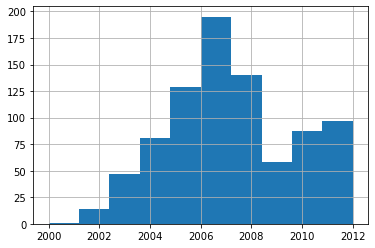

In [37]:
import matplotlib.pyplot as plt 
data['radyear'].hist()

In [42]:
data['radyear'].describe()

count     849.000000
mean     2007.068316
std         2.583519
min      2000.000000
25%      2005.000000
50%      2007.000000
75%      2009.000000
max      2012.000000
Name: radyear, dtype: float64

# Data Explory Zone

In [60]:
df['deathYN']=[1 if not pd.isnull(x) else -1 for x in df['radyear']]

In [62]:
temp=df.loc[df['deathYN']==1,].copy()
for col in temp.columns:
    print(col, sum(temp[col].isnull()))

idauniq 0
pn 0
rabyear 0
radyear 0
male 0
white 0
migrantYN 2
currentpaternered 0
Zfatherseduc 849
Zmotherseduc 849
carersocc 256
rachshlt 591
everdivorced 0
nevermarried 0
ZincomeT 248
ZwealthT 248
Zeduccat 71
everunemployed 0
everrent 0
Zneighcohesion 160
Zneighdisorder 170
rocc 794
alcoholYN 0
everalcoholYN 0
currsmokeYN 0
eversmokeYN 0
vigactivityYN 273
sleepYN 0
Zposchildren 442
Znegchildren 443
Zposfamily 440
Znegfamily 450
Zposfriends 425
Znegfriends 427
Znegspouse 547
Zloneliness 393
Zlifesatis 389
Zdailydiscrim 808
deathYN 0
